# Introduction

This notebook can be used to visualize the consistency of your ThorLABS PAX1000 Digital Polarimeter's measurement rate.

See the Dataset Class section for the code, and the Example Usage section for examples on how to use it.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import warnings
import os

plt.ioff() #https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ioff.html
plt.close('all')

# Dataset Class

***

**Dataset(filename, set_range=None)**
<br>The dataset class is designed to read, store, and perform operations on a CSV dataset from the PAX1000 digital polarimeter.
Cleaning of the CSV file happens automatically upon initialization of a Dataset instance, and assumes the CSV was output from the PAX1000 software (e.g., there are 7 header rows containing the dataset parameters, 1 row of whitespace, and 1 row of the column names, below which are the data (observations)). See the PAX [manual](https://www.manualslib.com/manual/1634678/Thorlabs-Pax1000.html?page=39#manual) for details on the recorded quantities.

**Parameters**
<br>*filename : string*
> Path to PAX csv file to analyze, e.g. "Datasets/my_dataset.csv" if your csv file is in a folder named 'Datasets'

*set_range : None or tuple of two floats, optional*
> If None, the entire dataset will be analyzed (default behavior).
> <br>Use tuple of two floats to specify a part of a dataset to read in, given via percentages. This is usually useful to save time while reading in a small portion of a large dataset. For example, set_range=(0.05,0.1) means the chunk of the dataset between 5%-10%.

***

***

**Dataset.rate_hist(log=True, bins=50, xmax=None)**
<br>Visualize the consistency of the PAX's measurement rate. Generate and plot the histogram of time differences between subsequent points.

**Parameters**
<br>*log : boolean, optional*
> Whether to make the y-axis log-scale. Emphasizes uncommon occurrences. Default is True.

*bins : int, optional*
> Increase or decrease bin width depending on size and range of dataset. Default is 50.

*xmax : None or float, optional*
> Set a maximum on the x-axis (for easier viewing) if there is one outlying point far out on the x-axis.

***

***

**Dataset.plot(plot_param='s1', sample_range=None, birds_eye=True)**
<br>Plot some parameter in the dataset over time.

**Parameters**
<br>*plot_param : string, optional*
> The parameter(s) to plot. Default is "AllStokes" (all normalized stokes parameters). Options are:
> - AllStokes, s1, s2, s3, S0, S1, S2, S3, Azimuth, Ellipticity, DOP, DOCP, DOLP, Power, Power_pol, Power_unpol

*sample_range : None or tuple of two floats, optional*
> A portion of the plot to zoom in on, given in seconds, e.g. sample_range=(50,100)

*birds_eye : boolean, optional*
> Whether or not to show the birds eye view

***

In [22]:
class Dataset:
    stokes_units = 'W/m^2'
    unitless = 'unitless'
    radians = 'Rad'; degrees = 'Degrees'
    UNITS = {'S0':stokes_units, 'S1':stokes_units, 'S2':stokes_units, 'S3':stokes_units,
                  's1':unitless, 's2':unitless, 's3':unitless, 'AllStokes':unitless,
                  'Azimuth':degrees, 'Ellipticity':degrees,
                  'NumPoints':'number',
                  'DOP':'%', 'DOCP':'%', 'DOLP':'%', 'Power':'mW', 'Power_pol':'mW', 'Power_unpol':'mW'}
    
    def __init__(self, filename, set_range=None):
        self.title = filename
        self.filename = filename
        
        # Cleaning of the data happens in Dataset.read_pax_data
        df, num_points_dropped, device_id, serial_num, wavelength, basic_sample_rate, op_mode_period, \
            op_mode_FFT_num = Dataset.read_pax_data(filename,set_range)
        self.device_id = device_id
        self.serial_num = serial_num
        self.wavelength = wavelength
        self.basic_sample_rate = basic_sample_rate
        self.op_mode_period = op_mode_period
        self.op_mode_FFT_num = op_mode_FFT_num
        self.num_points_dropped = num_points_dropped
        self.df = df
        self.num_points = df.shape[0]
        self.time_elapsed = df['TimeElapsed'][self.num_points-1]
        
        self.mintime = df.loc[0, 'TimeElapsed']
        self.maxtime = df.loc[df.shape[0]-1, 'TimeElapsed']
        print('Time range: min={}, max={}'.format(self.mintime, self.maxtime))
        
        self.nominal_sample_rate = basic_sample_rate / (2*op_mode_period)
        self.avg_sample_rate = 1/(df['TimeDiff'][1:].mean())   # See rate_hist for why this code
        return
    
    @staticmethod
    def read_pax_data(filename, set_range=None):
        # Get one-off information in the header
        df_temp = pd.read_csv(filepath_or_buffer=filename, delimiter=';', header=None, usecols=[1], nrows=7)
        device_id = df_temp.iat[0,0]
        serial_num = df_temp.iat[1,0]
        wavelength = float(df_temp.iat[4,0])
        basic_sample_rate = float(df_temp.iat[5,0])
        op_mode = df_temp.iat[6,0] #operating mode string
        p_end_index = op_mode.find(' rev')
        n_start_index = op_mode.find('ent, ') + 5
        n_end_index = op_mode.find(' poi')
        op_mode_period = float(op_mode[:p_end_index]) #P part of string
        op_mode_FFT_num = int(op_mode[n_start_index:n_end_index]) #N part of string
        # File looks like 7 rows of info (do display(df.head())), 1 row of whitespace, 1 row of column names, then the data
        
        with open(filename) as f:
            total_rows = sum(1 for line in f) - 9   # The first 9 rows are info, whitespace, and column names
        skiprows = nrows = None   # Initally assume we read all of the file
        if set_range is not None:
            per_start, per_end = set_range
            # set_range parameters refer to percentages (e.g. (0.4,0.6) is 40% to 60% of the dataset)
            # If per_start isn't None, skiprows is a number. If per_end isn't None, nrows is rows to use
            skiprows = None if per_start is None else int(total_rows * per_start)
            nrows = None if per_end is None else int(total_rows * (per_end-(0.0 if per_start is None else per_start)))
            # If either of these were changed from None, read_csv will notice and use them appropriately in rad_csv
        
        # TODO: fix warning
        # Catching a FutureWarning for infer_datetime_format;
        # the code works and I don't want to deal with the red text right now
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", FutureWarning)
            ### read in, assign labels and variable types
            df = pd.read_csv(filepath_or_buffer=filename, delimiter=';', header=7, skiprows=skiprows, nrows=nrows,
                             parse_dates=['Timestamp'], infer_datetime_format=True,
                             names=['Timestamp', 'TimeDelta', 's1', 's2', 's3', 'S0', 'S1', 'S2', 'S3',
                                    'Azimuth', 'Ellipticity', 'DOP', 'DOCP', 'DOLP', 'Power', 'Power_pol', 'Power_unpol',
                                    'Power_total_dB', 'Power_pol_dB', 'Power_unpol_dB', 'Power_split_ratio',
                                    'Phase_difference', 'Warning'],
                             dtype={'Warning': 'string'})

        # drop unneeded columns
        df.drop(columns=['Power_total_dB', 'Power_pol_dB', 'Power_unpol_dB', 'Warning'],inplace=True)

        indices_with_missing_values = df[df.isna().any(axis=1)].index # Find the indices of rows with missing values
        df = df.drop(indices_with_missing_values) # Drop rows with missing values
        df = df.reset_index(drop=True) # Re-index the DataFrame
        num_points_dropped = len(indices_with_missing_values)

        # format timestamp
        def custom_to_timedelta(s):
            days, time = s.split('.')
            hours, minutes, seconds, milliseconds = map(int, time.split(':'))
            return timedelta(days=int(days), hours=hours, minutes=minutes, seconds=seconds, milliseconds=milliseconds)
        df['TimeDelta'] = df['TimeDelta'].apply(custom_to_timedelta) # convert to timedelta
        df['TimeElapsed'] = df['TimeDelta'].apply(lambda x: x.total_seconds()) # Seconds elapsed since first measurement
        # The raw DateTime and TimeDelta objects are no longer needed
        #df.drop(columns=['Timestamp','TimeDelta'], inplace=True)
        df.drop(columns=['TimeDelta'], inplace=True)   # Actually, want to display global datetime on plots
        
        ### Calculate the time difference between current and previous measurements
        df['TimeDiff'] = df['TimeElapsed'].diff()
        df.loc[0, 'TimeDiff'] = 0

        # rearrange columns
        cols = df.columns.tolist()
        cols = cols[-2:] + cols[:-2] # move TimeElapsed and TimeDiff to front
        df = df[cols]
        
        return df, num_points_dropped, device_id, serial_num, wavelength, basic_sample_rate, op_mode_period, \
            op_mode_FFT_num
    
    # Used by plot functions to display the global time being plotted
    # E.g. a 2 hour dataset may be "11:36 - 13:45" (we use a 24 hour clock)
    # Input the dataframe we're plotting from, and the start/end time w/ respect to the dataframe (e.g. 2000 seconds)
    @staticmethod
    def gen_time_str(df, start_time=None, end_time=None):
        start_ind = 0 if start_time is None else df.index[df['TimeElapsed'] >= start_time].min()
        end_ind = len(df)-1 if end_time is None else df.index[df['TimeElapsed'] <= end_time].max()
        time_str_start = df.loc[start_ind,'Timestamp'].strftime('%H:%M')
        time_str_end = df.loc[end_ind,'Timestamp'].strftime('%H:%M')
        return '{:s} - {:s}'.format(time_str_start,time_str_end)
    
    
    def plot(self,plot_param='AllStokes',sample_range=None,birds_eye=True):
        # Plot entire dataset if requested
        if plot_param=='AllStokes':
            params_array=[('s1','red'),
                    ('s2','blue'),
                    ('s3','purple')]
        else:
            params_array=[(plot_param,'red')]
        
        ### Plots specified parameter over time
        BE_fig=None
        if birds_eye:
            BE_fig, BE_ax = plt.subplots(figsize=(12,3))
            for param,color in params_array:
                BE_ax.plot(self.df['TimeElapsed'], self.df[param], label=param, linewidth=0.5, marker='o', markersize=0.8, color=color, alpha=0.5)
            BE_ax.set_xlabel('Time [s]')
            BE_ax.set_title('{:s} | {:s} | {:s}'.format(plot_param, self.title, Dataset.gen_time_str(self.df)), fontsize=14, fontweight='bold')
            BE_ax.set_ylabel('{:s} [{:s}]'.format(plot_param,self.UNITS.get(plot_param,'TODO')))
            BE_ax.grid(True)
            BE_ax.legend(loc='upper right')
            # We add green lines to the birds eye plot to denote where sample_range is located
            if sample_range is not None:
                for val in sample_range:
                    BE_ax.axvline(val, color = 'green', linewidth=2)
            BE_fig.tight_layout()
            display(BE_fig); plt.close(BE_fig)   # Show entire dataset
        
        # If requested, we'll also plot the smaller sample range
        ZI_fig=None
        if sample_range is not None:
            # Plot of specified sample
            ZI_fig, ZI_ax = plt.subplots(figsize=(12,3))
            for param,color in params_array:
                ZI_ax.plot(self.df['TimeElapsed'], self.df[param], label=param, linewidth=1, marker='o', markersize=1.5, color=color)
            ZI_ax.set_xlabel('Time [s]')
            ZI_ax.set_title('{:s} | {:s} | {:s}'.format(plot_param, self.title, Dataset.gen_time_str(self.df, sample_range[0], sample_range[1])), fontsize=14, fontweight='bold')
            ZI_ax.set_ylabel('{:s} [{:s}]'.format(plot_param,self.UNITS.get(plot_param,'TODO')))
            ZI_ax.grid(True)
            ZI_ax.legend(loc='upper right')
            ZI_ax.set_xlim(sample_range[0],sample_range[1])
            ZI_fig.tight_layout()
            display(ZI_fig); plt.close(ZI_fig)
        
        return
    
    ### Generate histogram of time differences
    def rate_hist(self, log=True, bins=50, xmax=None):
        timedif = self.df['TimeDiff'][1:]   # Get time diffs, excluding first entry (which is 0)
        if (xmax != None) & np.any(timedif > xmax):
            print("Warning: Data beyond xmax={:f} in {:s}".format(xmax, self.title))
        fig, ax = plt.subplots(figsize=(12,3))
        # plot the histogram of time differences; only change x range if given
        ax.hist(timedif, bins=bins, align='mid', range=(0,xmax) if xmax else None, alpha=0.75)
        
        # Changing limits, adding titles
        if xmax != None:
            ax.set_xlim(0,xmax)
        else:
            ax.set_xlim(left=0)
        ax.set_xlabel('Time Between Samples [s]')
        if log:
            ax.set_yscale('log')
            #ax.set_ylabel('Frequency (log scale)')
            log_title_string = '(log scale) '
        else:
            #ax.set_ylabel('Frequency')
            log_title_string = ''
        ax.set_title('Time Between Samples (TBS) Histogram {:s}| {:s}'.format(log_title_string,self.title), fontsize=12, fontweight='bold')
        ax.grid(True)
        
        # Label statistics on plot
        ax.axvline(x=1/self.nominal_sample_rate, color='red', linestyle='--')   # Indicate nominal time dif
        timedif_avg = timedif.mean()   # Actual time dif (avg of all time diffs)
        timedif_std = timedif.std()   # STD of time diffs
        ax.axvline(x=timedif_avg, color='blue', linestyle='--')   # Indicate actual time dif
        ax.hlines(1, timedif_avg, timedif_avg+timedif_std, color='purple', lw=2)   # Indicate STD
        
        # Print statistics
        lines = [("Averaging Periods = {:.1f} ".format(self.op_mode_period), 'black'),
                ("FFT Points = {:d}".format(self.op_mode_FFT_num), 'black'),
                ("Basic Sample Rate = {:.0f} samples/s".format(self.basic_sample_rate), 'black'),
                ("Configured Sample Rate = {:.1f} samples/s".format(self.nominal_sample_rate), 'red'),
                ("Average Sample Rate = {:.1f} samples/s".format(self.avg_sample_rate), 'blue'),
                ("", 'black'),
                ("Configured TBS = {:.4f} s".format(1/self.nominal_sample_rate), 'red'),
                ("Average TBS = {:.4f} s".format(timedif_avg), 'blue'),
                ("TBS STD = ±{:.4f} s".format(timedif_std), 'purple')]
        x_pos = 0.95
        y_pos = 0.95
        line_height = 0.08
        # Plot markers for zoomed-in view on birds eye plot
        for i in range(len(lines)):
            text, color = lines[i]
            ax.text(x_pos, y_pos - i*line_height, text, color=color, horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
        fig.tight_layout()
        display(fig); plt.close(fig)
        return

# Example usage

**Create Dataset object**
* Define path to .csv file.
* Initializing Dataset object reads and cleans data.
* To perform analysis only on a section of the dataset, use "set_range" parameter as described above.

**Use Dataset.rate_hist() to visualize the TBS (time between samples) distribution**
* Set "bins" parameter manually if default value of 50 does not properly account for amount of data.

**Use Dataset.plot() to visualize the time-domain SOP measurements**
* To view specific section of data, use "sample_range" parameter as described above.

Time range: min=0.069, max=120.013


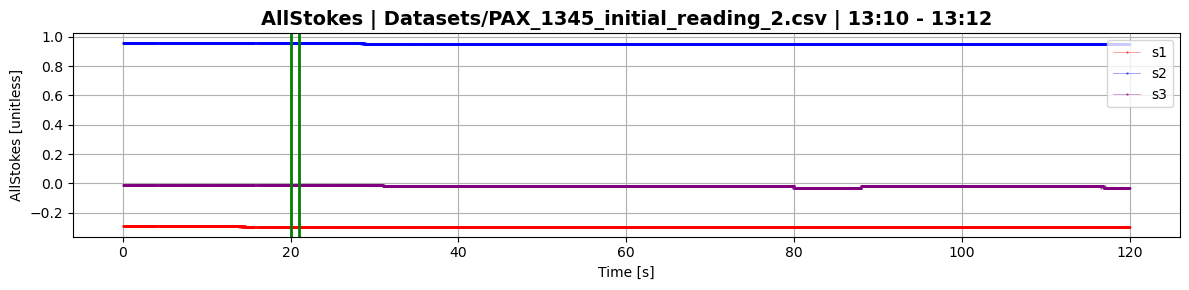

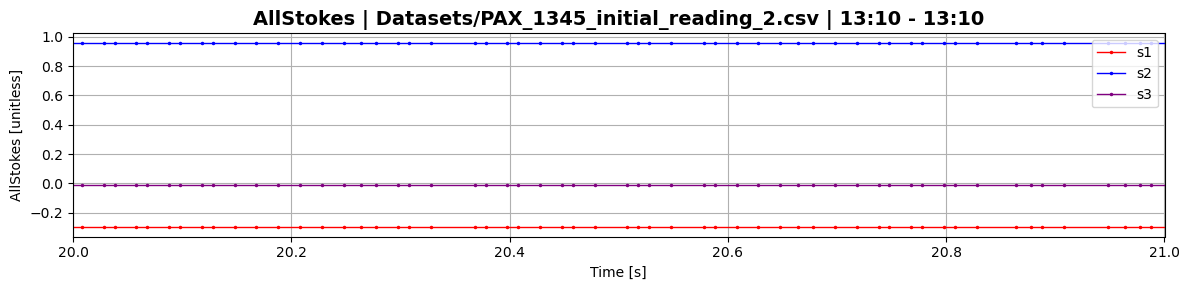

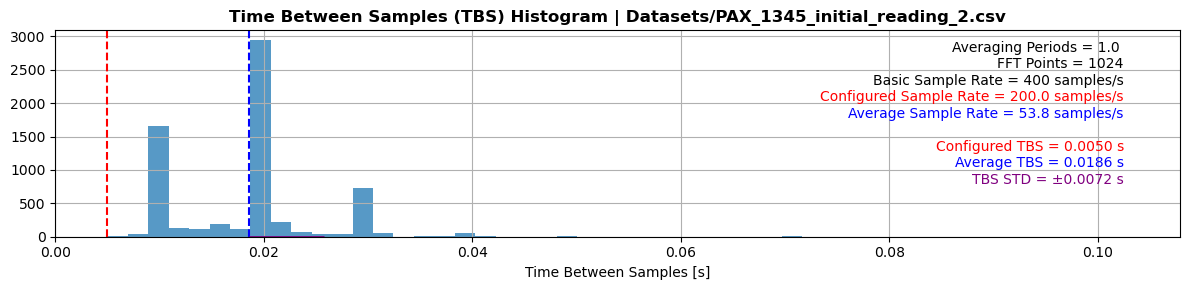

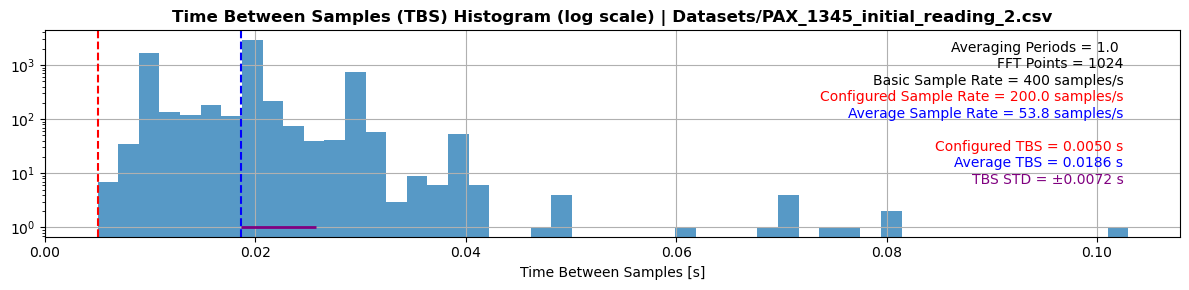

In [23]:
filename='Datasets/PAX_1345_initial_reading_2.csv'
#filename='Datasets/PAX_1345_initial_reading_1.csv'
#filename='Datasets/PAX_08-16_30m_ADev_3_1560.csv'
#filename='Datasets/PAX_08-16_ARL_ADev_2_1560.csv'
my_dataset = Dataset(filename,set_range=None)
my_dataset.plot(plot_param='AllStokes',sample_range=(20,21))
my_dataset.rate_hist(log=False)
my_dataset.rate_hist()